In [1]:
pwd

u'/Users/gaoxiang/PycharmProjects/Neural_Network/tensorflow_tutorial/06_cifar10'

In [2]:
import tensorflow as tf
import numpy as np
from data_provider.data_providers import CIFAR10DataProvider
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt

In [3]:
# load data set
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)


# set the image parameters

# Width and height of each image.
img_size = 32
# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3
# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels
# Number of classes.
num_classes = 10
# The images are 32 x 32 pixels, but we will crop the images to 24 x 24 pixels.
img_size_cropped = 24

In [4]:
# get training and validation data

# get a list of class names
class_names = train_data.label_map
# get training images set
images_train = train_data.inputs.reshape((-1, num_channels, img_size, img_size)).transpose(0,2,3,1).astype(np.float32)
# get validation images set
images_valid = valid_data.inputs.reshape((-1, num_channels, img_size, img_size)).transpose(0,2,3,1).astype(np.float32)
# training set class numbers
cls_train = train_data.targets
# validation set class numbers
cls_valid = valid_data.targets
# training set labels
labels_train = train_data.to_one_of_k(train_data.targets)
# validation set labels
labels_valid = valid_data.to_one_of_k(valid_data.targets)

In [5]:
# Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :], interpolation=interpolation)

        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

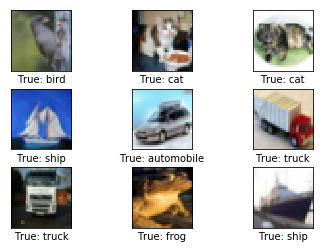

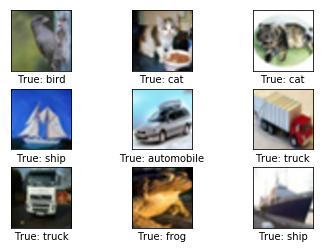

In [6]:
# Plot the images and labels using our helper-function above.
plot_images(images=images_train[0:9], cls_true=cls_train[0:9], smooth=False)
# The pixelated images above are what the neural network will get as input.
# The images might be a bit easier for the human eye to recognize if we smoothen the pixels.
plot_images(images=images_train[0:9], cls_true=cls_train[0:9], smooth=True)

In [7]:
# set placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [8]:
# Helper-function for creating Pre-Processing
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.

    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)

        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For validation, only crop the input image

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

In [9]:
# The function above is called for each image in the input batch using the following function.
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

In [10]:
# In order to plot the distorted images, we create the pre-processing graph for TensorFlow.
distorted_images = pre_process(images=x, training=True)

In [11]:
# The following helper-function creates the main part of the convolutional neural network.
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)

    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer

    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

    return y_pred, loss

In [12]:
# The following helper-function creates the full neural network, which consists
#  of the pre-processing and main-processing defined above.
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during validation testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x

        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)

        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

In [13]:
# Create Neural Network for Training Phase
# First create a TensorFlow variable that keeps track of the number of optimization iterations performed so far.
# I want to save this variable with all the other TensorFlow variables in the checkpoints.
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)
# Create the neural network to be used for training.
_, loss = create_network(training=True)
# Create an optimizer which will minimize the loss-function. Also pass the global_step variable to the optimizer
# so it will be increased by one after each iteration.
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)

In [14]:
# Create Neural Network for validation test phase
y_pred, _ = create_network(training=False)
# Calculate the predicted class number as an integer. The output of the network y_pred is an array with 10 elements.
# The class number is the index of the largest element in the array.
y_pred_cls = tf.argmax(y_pred, dimension=1)
# Then create a vector of booleans telling us whether the predicted class equals the true class of each image.
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
# The classification accuracy is calculated by first type-casting the vector of booleans to floats, and then
# taking the average of these numbers.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
# In order to save the variables of the neural network, so they can be reloaded quickly without having to 
# train the network again, now create a so-called Saver-object which is used for storing and retrieving 
# all the variables of the TensorFlow graph.
saver = tf.train.Saver()

In [16]:
# Getting the Weights
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable

In [17]:
# Helper-function to retrieve the last tensor that is output by the convolutional layer.
def get_layer_output(layer_name):
    # The name of the last operation of the convolutional layer.
    # This assumes you are using Relu as the activation-function.
    tensor_name = "network/" + layer_name + "/Relu:0"

    # Get the tensor with this name.
    tensor = tf.get_default_graph().get_tensor_by_name(tensor_name)

    return tensor

In [18]:
# get the weights and convolutional layer output for visualisation later.
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')
output_conv1 = get_layer_output(layer_name='layer_conv1')
output_conv2 = get_layer_output(layer_name='layer_conv2')

In [19]:
# Create a TensorFlow session which is used to execute the graph.
session = tf.Session()

In [20]:
# Restore or initialize variables
save_dir = 'checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'cifar10_cnn')

In [21]:
# First try to restore the latest checkpoint.
try:
    print("Trying to restore last checkpoint ...")

    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
('Restored checkpoint from:', u'checkpoints/cifar10_cnn-120000')


In [22]:
train_batch_size = 64
# Function for selecting a random batch of images from the training-set.
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

In [23]:
# Helper-functions for calculating classifications
batch_size = 256
def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :],
                     y_true: labels[i:j, :]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [24]:
# Calculate the predicted class for the validation set.
def predict_cls_test():
    return predict_cls(images = images_valid,
                       labels = labels_valid,
                       cls_true = cls_valid)

In [25]:
# Helper-functions for the classification accuracy
def classification_accuracy(correct):
    
    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [26]:
# Function for printing the classification accuracy on the validation set.
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):
    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()

    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)

    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [27]:
# Helper-function for plotting convolutional weights
def plot_conv_weights(weights, input_channel=0):

    # Retrieve the values of the weight-variables from TensorFlow.
    w = session.run(weights)

    # Print statistics for the weights.
    print("Min:  {0:.5f}, Max:   {1:.5f}".format(w.min(), w.max()))
    print("Mean: {0:.5f}, Stdev: {1:.5f}".format(w.mean(), w.std()))

    # Get the lowest and highest values for the weights.
    w_min = np.min(w)
    w_max = np.max(w)
    abs_max = max(abs(w_min), abs(w_max))

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    num_grids = int(math.ceil(math.sqrt(num_filters)))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_filters:
            
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=-abs_max, vmax=abs_max,
                      interpolation='nearest', cmap='seismic')

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [28]:
# Helper-function for plotting the output of convolutional layers
def plot_layer_output(layer_output, image):

    # Create a feed-dict which holds the single input image.
    feed_dict = {x: [image]}

    # Retrieve the output of the layer after inputting this image.
    values = session.run(layer_output, feed_dict=feed_dict)

    # Get the lowest and highest values.
    values_min = np.min(values)
    values_max = np.max(values)

    # Number of image channels output by the conv. layer.
    num_images = values.shape[3]

    # Number of grid-cells to plot.
    num_grids = int(math.ceil(math.sqrt(num_images)))

    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid image-channels.
        if i < num_images:
            # Get the images for the i'th output channel.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, vmin=values_min, vmax=values_max,
                      interpolation='nearest', cmap='binary')

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [29]:
# Examples of distorted input images
def plot_distorted_image(image, cls_true):
    # Repeat the input image 9 times.
    image_duplicates = np.repeat(image[np.newaxis, :, :, :], 9, axis=0)

    # Create a feed-dict for TensorFlow.
    feed_dict = {x: image_duplicates}

    # Calculate the pre-processing of the TensorFlow graph
    # which distorts the images in the feed-dict.
    result = session.run(distorted_images, feed_dict=feed_dict)

    # Plot the images.
    plot_images(images=result, cls_true=np.repeat(cls_true, 9))

In [30]:
# Helper-function for getting an image and its class-number from the validation set.
def get_test_image(i):
    return images_valid[i, :, :, :], cls_valid[i]

In [31]:
# Helper-function to save the record into the file
def save_file(filename, number, accuracy):
    f = open(filename, 'a')
    f.write(str(number) + '\t' + str(accuracy) + '\n')
    f.close()

In [32]:
# Helper-function to perform optimization
# This function performs a number of optimization iterations so as to gradually improve the variables of the network layers.
# In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using
# those training samples. The progress is printed every 100 iterations. A validation accuracy test is performed every 500 iterations.
# A checkpoint is saved every 1000 iterations and also after the last iteration.
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            # Save to the file.
            save_file('train_data_augmentation.txt', i_global, batch_acc)

        # Save the validation accuracy to the file every 500 iterations
        if (i_global % 500 == 0):
            # Get the classification accuracy on validation set
            correct, cls_pred = predict_cls_test()
            acc, num_correct = classification_accuracy(correct)
            msg = "Global Step: {0:>6}, Validation Set Accuracy: {1:>6.1%}"
            print(msg.format(i_global, acc))
            save_file('valid_data_augmentation.txt', i_global, acc)

        # Save a checkpoint to disk every 1000 iterations (and last).
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session,
                       save_path=save_path,
                       global_step=global_step)

            print("Saved checkpoint.")

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [33]:
# Function for plotting examples of images from the test-set that have been mis-classified.
def plot_example_errors(cls_pred, correct):

    # Negate the boolean array.
    incorrect = (correct == False)

    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_valid[incorrect]

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_valid[incorrect]

    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [34]:
# Helper-function to plot confusion matrix
def plot_confusion_matrix(cls_pred):

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_valid,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

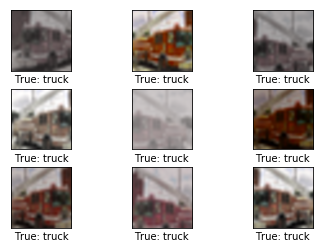

In [35]:
# Get an image and its true class from the validation set.
img, cls = get_test_image(16)
# Plot 9 random distortions of the image. If you re-run this code you will get slightly different results.
plot_distorted_image(img, cls)

In [36]:
# Perform optimization
optimize(num_iterations=30000)

Global Step: 120100, Training Batch Accuracy:  90.6%
Global Step: 120200, Training Batch Accuracy:  87.5%
Global Step: 120300, Training Batch Accuracy:  85.9%
Global Step: 120400, Training Batch Accuracy:  87.5%
Global Step: 120500, Training Batch Accuracy:  87.5%
Global Step: 120500, Validation Set Accuracy:  78.3%
Global Step: 120600, Training Batch Accuracy:  92.2%
Global Step: 120700, Training Batch Accuracy:  85.9%
Global Step: 120800, Training Batch Accuracy:  89.1%
Global Step: 120900, Training Batch Accuracy:  85.9%
Global Step: 121000, Training Batch Accuracy:  81.2%
Global Step: 121000, Validation Set Accuracy:  78.4%
Saved checkpoint.
Global Step: 121100, Training Batch Accuracy:  87.5%
Global Step: 121200, Training Batch Accuracy:  82.8%
Global Step: 121300, Training Batch Accuracy:  93.8%
Global Step: 121400, Training Batch Accuracy:  85.9%
Global Step: 121500, Training Batch Accuracy:  90.6%
Global Step: 121500, Validation Set Accuracy:  79.1%
Global Step: 121600, Trainin

Accuracy on Test-Set: 78.8% (7883 / 10000)
Example errors:


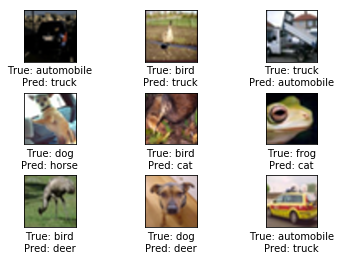

Confusion Matrix:
(array([822,  21,  43,  20,   9,   7,   3,  11,  26,  38]), '(0) airplane')
(array([ 17, 894,   3,   8,   0,   6,   6,   2,  11,  53]), '(1) automobile')
(array([ 48,   3, 731,  57,  42,  49,  24,  25,  11,  10]), '(2) bird')
(array([ 13,   3,  41, 603,  53, 194,  34,  31,  10,  18]), '(3) cat')
(array([ 18,   5,  43,  57, 728,  53,  24,  51,   5,  16]), '(4) deer')
(array([  3,   6,  19, 140,  26, 750,  17,  26,   2,  11]), '(5) dog')
(array([ 15,  10,  29,  45,  31,  28, 815,   9,   8,  10]), '(6) frog')
(array([  7,   6,  18,  48,  33,  46,   1, 828,   2,  11]), '(7) horse')
(array([ 57,  32,  12,  14,   5,   4,   8,   1, 822,  45]), '(8) ship')
(array([ 10,  47,   9,  12,   1,   3,   2,   6,  20, 890]), '(9) truck')
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9)


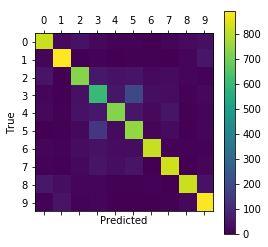

Min:  -0.60971, Max:   0.65246
Mean: -0.00090, Stdev: 0.16861


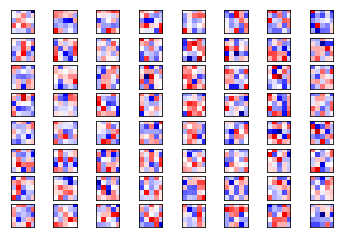

Min:  -0.75277, Max:   0.25174
Mean: -0.00398, Stdev: 0.05507


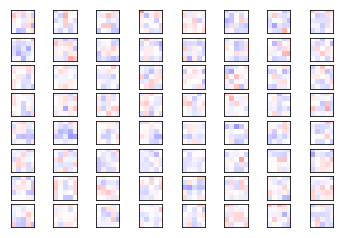

In [37]:
# show results
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)
plot_conv_weights(weights=weights_conv1, input_channel=0)
plot_conv_weights(weights=weights_conv2, input_channel=0)

In [38]:
# Helper-function for plotting an image.
def plot_image(image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 2)

    # References to the sub-plots.
    ax0 = axes.flat[0]
    ax1 = axes.flat[1]

    # Show raw and smoothened images in sub-plots.
    ax0.imshow(image, interpolation='nearest')
    ax1.imshow(image, interpolation='spline16')

    # Set labels.
    ax0.set_xlabel('Raw')
    ax1.set_xlabel('Smooth')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

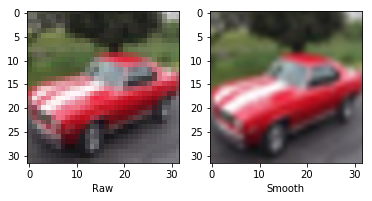

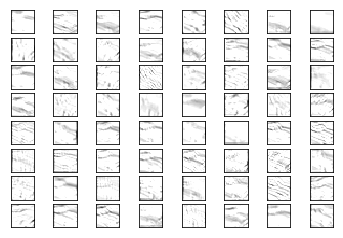

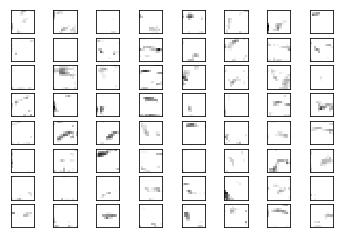

(array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32), 1)


In [39]:
# Choose an image, plot the output of the two convolutional layer of this image, and show the predicted class.
img, cls = get_test_image(10)
plot_image(img)

plot_layer_output(output_conv1, image=img)
plot_layer_output(output_conv2, image=img)

label_pred, cls_pred = session.run([y_pred, y_pred_cls], feed_dict={x: [img]})

# Set the rounding options for numpy.
np.set_printoptions(precision=3, suppress=True)
# Print the predicted label.
print(label_pred[0], cls_pred[0])